## <span style="color:darkblue; font-weight:bold"> GLM 🔍📊📈</span>

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the input data
csv = pd.read_csv("../1_datasets/simcomms/processed_data_simcomms_0.5_full_jun16", index_col="sample")
csv = csv.drop(['transfer', 'reached_fixation_at',
               'filename', 'initial_size', 'final_size',
               'filt_even', 'filt_shannon',
#                                                              'gini', 'raw_even',
#                                                              'richness',
#                                                               'distrib'
               ], axis=1)

csv = csv.dropna()
csv = csv.replace(to_replace="1.00E+06", value=100000)
csv.distrib = [1 if i=="uniform" else 0 for i in csv.distrib]

# Filter by dilution factor (!!!!)
csv = csv[csv.dilfactor < 0.01]
csv = csv[csv.dilfactor > 0.00025]

# Separate the input variables (features) and the output variable (target)
X = csv.drop("success", axis=1)
y = csv["success"]

# out
prefix = "GLM/"

sample
1_lognorm_10000_1000     3.0
2_lognorm_10000_1000     3.0
5_lognorm_10000_1000     2.0
6_lognorm_10000_1000     2.0
7_lognorm_10000_1000     3.0
                        ... 
26_uniform_10000_10     19.0
27_uniform_10000_10     19.0
28_uniform_10000_10     19.0
29_uniform_10000_10     18.0
30_uniform_10000_10     19.0
Name: success, Length: 1845, dtype: float64


### <span style="color:darkblue; font-weight:bold"> 1. Distribution </span>
#### First we need to decide on the distribution for the success variable

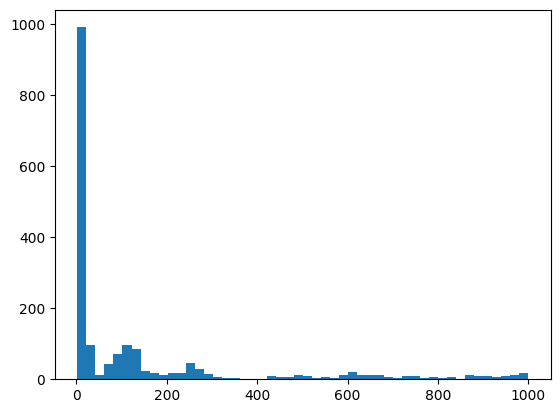

In [2]:
plt.hist(y, 50)
plt.show()

#### It looks like an exponential negative (more or less). But when log'ing it we see what looks like a mixture distribution

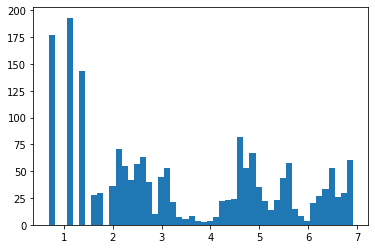

In [ ]:
plt.hist(np.log(y), 50)
plt.show()

Now we normalize X and create the model

In [3]:
# Normalize the variables in X
variable_names = X.columns.tolist()
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns = variable_names)

# Fit the GLM with a negative exponential distribution
model = sm.GLM(list(y), sm.add_constant(X_normalized), family=sm.families.Gamma(link=sm.families.links.log()))
result = model.fit()

# Show fitted model
print(result.summary())
coefficients = result.params
print(coefficients)

# Regression formula
regression_formula = "y = "
for i in range(len(variable_names)):
    coefficient = coefficients[i]
    variable_name = variable_names[i]
    regression_formula += f"({coefficient:.4f} * {variable_name}) + "

# Print the regression formula
print(regression_formula[0:-3])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1845
Model:                            GLM   Df Residuals:                     1837
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.15523
Method:                          IRLS   Log-Likelihood:                -7246.4
Date:                Thu, 22 Jun 2023   Deviance:                       350.56
Time:                        13:03:00   Pearson chi2:                     285.
No. Iterations:                    21   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.3679      0.206     -1.784      

- Really good pseudo R-squ. (CS):             0.9850

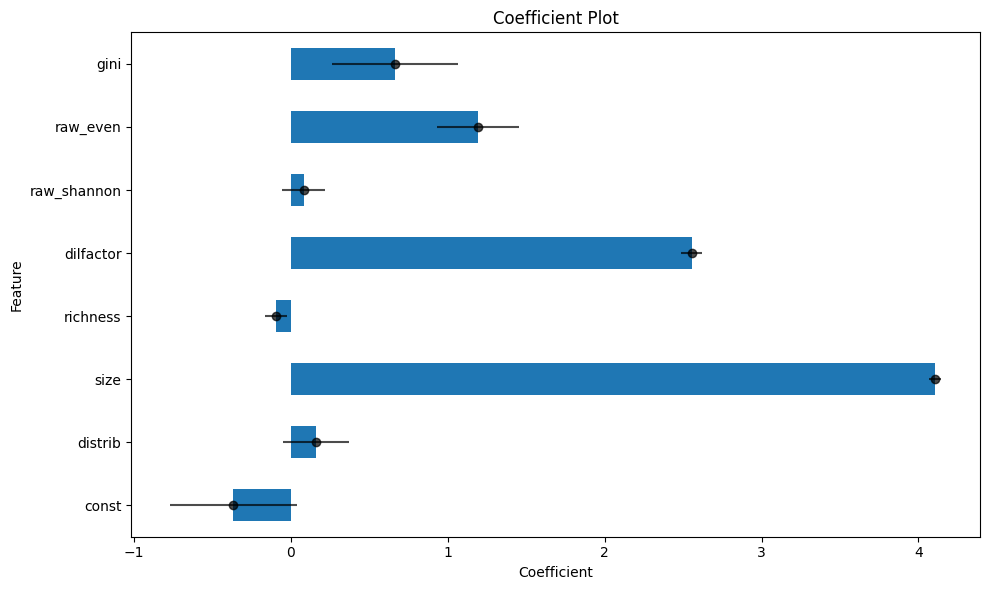

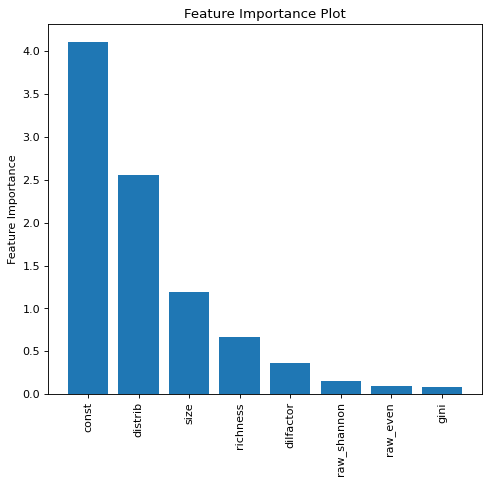

In [4]:
# Coefficient Plot
def plot_coefficients(result):
    coef_df = result.conf_int()
    coef_df['Coefficient'] = result.params
    coef_df.columns = ['Lower CI', 'Upper CI', 'Coefficient']
    coef_df.dropna(inplace=True)

    fig, ax = plt.subplots(figsize=(10, 6))
    coef_df['Coefficient'].plot(kind='barh', ax=ax)
    ax.errorbar(x=coef_df['Coefficient'], y=coef_df.index, xerr=(coef_df['Coefficient'] - coef_df['Lower CI'], coef_df['Upper CI'] - coef_df['Coefficient']),
                fmt='o', color='black', alpha=0.7)
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Feature')
    ax.set_title('Coefficient Plot')

    plt.tight_layout()
    plt.show()

plot_coefficients(result)

# Variable Importance Plot (importance==absolute value of coefficients
def plot_var_importance_plot(result, variable_names):
    importance_df = pd.DataFrame({'Variable': ["const"] + variable_names, # don't include constant
                                  'Importance': list(np.abs(result.params))})
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(7, 6), dpi=80)

    # Create a bar plot of the feature importances
    plt.bar(range(len(variable_names)+1), importance_df.Importance)

    # Add axis labels and a title to the plot
    plt.xticks(range(len(variable_names)+1), ["const"] + variable_names, rotation=90)
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Plot')

    # Add axis labels and a title to the plot
    plt.xticks(range(len(variable_names)+1), ["const"] + variable_names, rotation=90)
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance Plot')

    # Show the plot
    plt.savefig(prefix + "feature_importance.png")
    plt.show()
    plt.close()

plot_var_importance_plot(result, variable_names)

### <span style="color:darkblue; font-weight:bold"> Interactions</span>

In [5]:
interacting_vars = ['distrib', 'size', 'richness', 'dilfactor']
new_formula = "success ~ " + " + ".join(variable_names)

df_with_interactions = X_normalized.copy()
df_with_interactions["success"] = list(csv.success)

# Generate interaction terms between the features
for i, feature1 in enumerate(interacting_vars):
    for j, feature2 in enumerate(interacting_vars[i + 1:]):
        # “:” adds a new column to the design matrix with the interaction of the other two columns.
        # “*” will also include the individual columns that were multiplied together:
        interaction_name = feature1 + '**' + feature2
        df_with_interactions[interaction_name] = X_normalized[feature1] * X_normalized[feature2]
        # add to formula
        new_formula += f" + {feature1}:{feature2}"

# Fit the GLM model with the new formula
new_model = sm.formula.glm(formula=new_formula, data=df_with_interactions, family=sm.families.Gamma(link=sm.families.links.log()))
new_result = new_model.fit()

# Print the summary of the new model
print(new_result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                success   No. Observations:                 1845
Model:                            GLM   Df Residuals:                     1831
Model Family:                   Gamma   Df Model:                           13
Link Function:                    log   Scale:                         0.11923
Method:                          IRLS   Log-Likelihood:                -7057.7
Date:                Thu, 22 Jun 2023   Deviance:                       283.62
Time:                        13:03:00   Pearson chi2:                     218.
No. Iterations:                    27   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1392      0

- R² is much higher
- "distrib" is now not significant (pval == 0.741, while it was 0.03 before. According to chatGPT [**need source**]:

> A change in significance can occur when interaction terms are introduced because they may account for some of the variability that was previously attributed to individual variables.
> 
> In your case, "distrib" was initially significant when considered on its own (p-value of 0.03), but after including interaction terms in the model, its significance has changed (p-value of 0.741). This suggests that the effect of "distrib" on the log-odds of success may be better explained or captured when considering its interactions with other variables.

> When interaction terms are included in a model, they can modify the relationship between the individual variables and the outcome. This means that the interpretation and significance of the individual variables can change when interactions are taken into account. In your model, the interaction terms involving "distrib" (e.g., distrib:size, distrib:richness, distrib:dilfactor) might be capturing the explanatory power that was previously attributed solely to "distrib" as an individual variable.

> Therefore, it is important to consider the overall model fit, the significance of the interaction terms, and the changes in significance of individual variables when interpreting the results. While "distrib" may no longer be individually significant, its interactions with other variables are still significant, indicating that the combined effects of "distrib" with other variables are important for explaining the log-odds of success.

- As we could sense from the original scatter plots, the dilution factor has a strong effect on the success cycle, but it affects it very differently depending on the size and the richness of the original community.

In [6]:
new_coefficients = new_result.params
from IPython.display import display, Math

new_regression_formula = "y = "
for i in range(len(df_with_interactions.columns)):
    coefficient = new_coefficients[i]
    variable_name = df_with_interactions.columns[i]
    new_regression_formula += f"({coefficient:.4f} * {variable_name}) + "

print(new_regression_formula[:-3])

## Pretty print
#from sympy import symbols, latex
#
#distrib, size, richness, dilfactor, raw_shannon, raw_even, gini, success = symbols('distrib size richness dilfactor raw\_shannon raw\_even gini success')
#
#latex_formula = (0.7421 * distrib) + (-0.0506 * size) + (2.2318 * richness) + (-1.2562 * dilfactor) + (6.3968 * raw_shannon) + (-0.5516 * raw_even) + (1.6665 * gini) + (1.1215 * success) + (0.5758 * distrib**size) + (0.2358 * distrib**richness) + (5.3228 * distrib**dilfactor) + (1.1525 * size**richness) + (99.1201 * size**dilfactor) + (48.9552 * richness**dilfactor)
#latex_formula = latex(latex_formula)
#
#display(Math(latex_formula))

y = (0.1392 * distrib) + (-0.1722 * size) + (3.5423 * richness) + (-0.3114 * dilfactor) + (1.8544 * raw_shannon) + (0.4333 * raw_even) + (0.9007 * gini) + (0.3326 * success) + (0.2817 * distrib**size) + (-0.0218 * distrib**richness) + (0.4346 * distrib**dilfactor) + (0.1730 * size**richness) + (1.6709 * size**dilfactor) + (0.7710 * richness**dilfactor)


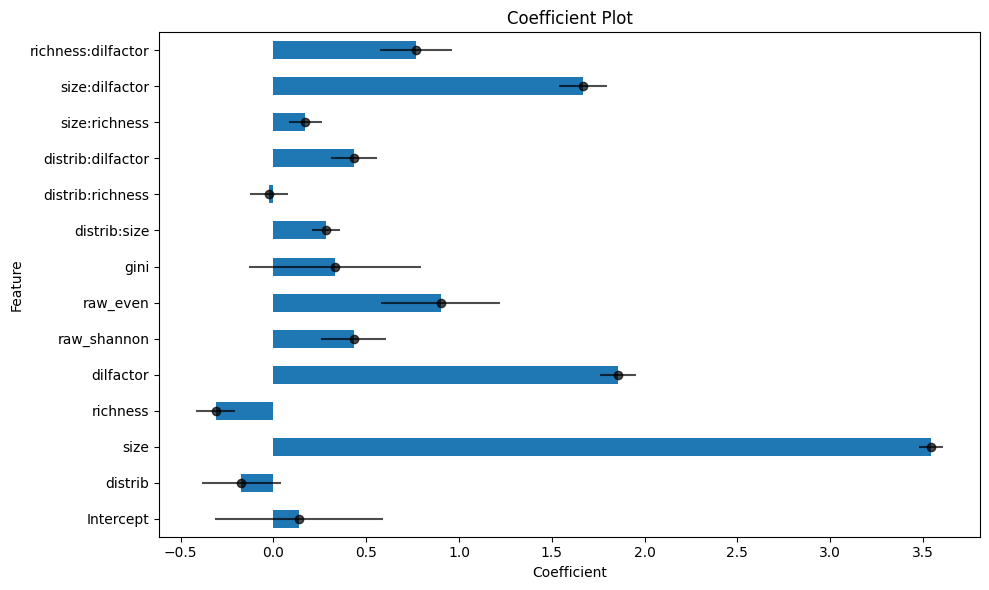

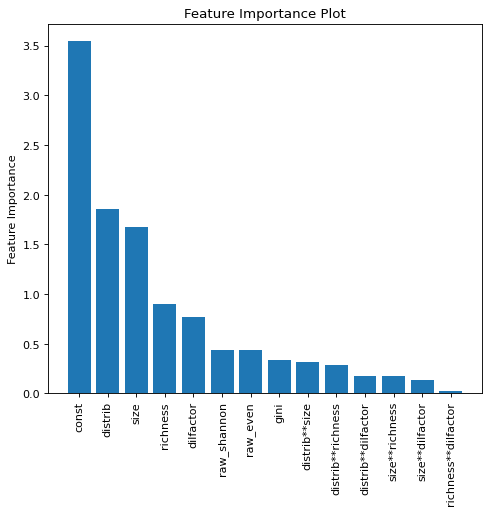

In [7]:
plot_coefficients(new_result)

plot_var_importance_plot(new_result, list(df_with_interactions.drop(["success"], axis=1).columns))

In [8]:
print(list(np.abs(new_result.params)))
["const"] + df_with_interactions.drop(["success"], axis=1).columns

[0.13921708619633075, 0.17218343625448082, 3.542277137152297, 0.3113903407950795, 1.8544405354450901, 0.4332983386655835, 0.9006515751532949, 0.3326432153106531, 0.28171731850805, 0.021785892116899613, 0.43462025357640405, 0.1729951529910996, 1.670890770473533, 0.770985533136556]


Index(['constdistrib', 'constsize', 'constrichness', 'constdilfactor',
       'constraw_shannon', 'constraw_even', 'constgini', 'constdistrib**size',
       'constdistrib**richness', 'constdistrib**dilfactor',
       'constsize**richness', 'constsize**dilfactor',
       'constrichness**dilfactor'],
      dtype='object')